### About

In a previous iPython notebook (likelihood_function_derivation.ipynb), we derived a 4-parameter likelihood function. While maximum likelihood estimation (MLE) approach captured experimental distributions with a high degree of accuracy, MLE does not (1) allow for the determination of estimate uncertainty or (2) allow for integration of prior knowledge of allelic incluions rates. In this notebook, we adapt our 4-parameter framework to allow for a Bayesian approach and, more specifically, direct approximation of the posterior distribution.

In [1]:
from math import factorial as fac
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats, optimize
from scipy.stats import rv_discrete
import pandas as pd
import warnings
from numba import jit
import emcee
%matplotlib inline

Recall, we have previously found:

### 4-parameter model:
$$
\begin{array}
\
p(x|\lambda,\gamma,f,s)&=&\displaystyle \frac{e^{-\lambda}(1-s)^x}{(1-e^{-\lambda})\zeta(\gamma,1)x!} \sum_{2m+n \geq x\geq1} \left(\sum\limits_{k=1}^{n+m} \frac{\lambda^{k}(n+m+1-k)^{-\gamma}}{k!}\right)\left(\frac{(m+n)!f^{m}(1-f)^{n}(2m+n)!s^{2m+n-x}}{(2m+n-x)!m!n!}\right)
\end{array}
$$

### Likelihood:

$$
\begin{array}
\
L&=&p({\rm data }|\lambda,f,\gamma,s) &=&\displaystyle \prod_i^N p(x_i|\lambda,\gamma,f,s) 
\end{array}
$$


### Bayesian approach:

We now wish to determine the probability of a particular parameter set given an experimental dataset ($p(\lambda,f,s)$). From Bayes' Thereom, we find:

$$
\begin{array}
\
p(\lambda,\gamma,f,s) &=&\displaystyle \frac{p({\rm data }|\lambda,\gamma,f,s) p(\lambda,\gamma,f,s)}{p(\rm data)}
\end{array}
$$

Here, $p(\lambda,\gamma,f,s)$ is referred to as the posterior probability and $p(\lambda,f,s)$ is the prior probability of a parameter set. As we model each parameter independently in our model, we will make the simplyfing assumption that:

$$
\begin{array}
\
p(\lambda,\gamma,f,s)&\approx&\displaystyle p(\lambda)p(\gamma)p(f)p(s)
\end{array}
$$

As we do not know, $\textit{a priori}$, what the distribution of parameter values should be, we will use uninformative (flat) priors for all parameters. 

Furthermore, $p(data)$ is a normalizing constant that ensures that integrating $p(data)$ overall all parameter values is equal to 1. Specifically:

$$
\begin{array}
\
p(data) &=&\displaystyle \int\limits_{-\infty}^{\infty} \int\limits_{-\infty}^{\infty} \int\limits_{-\infty}^{\infty} \int\limits_{-\infty}^{\infty} p({\rm data }|\lambda,\gamma, f,s) p(\lambda,\gamma, f,s) d\lambda d\gamma df ds &=&\displaystyle \int\limits_{0}^{\infty} \int\limits_{1}^{\infty} \int\limits_{0}^{1} \int\limits_{0}^{1} p({\rm data }|\lambda,\gamma, f,s) p(\lambda,\gamma, f,s) d\lambda d\gamma df ds
\end{array}
$$



As $p(data)$ cannot be calculated analytically, we will use Markov chain Monte Carlo (MCMC) simluations to sample from the posterior distribution. 

Starting with the simulation and likelihood function derived previously:

In [2]:
#Simulation code
def counts_from_x(x):
    counts_max=int(np.max(x))       
    counts=np.array([np.sum(1*x==i) for i in range(counts_max+1)])
    return counts

@jit
def loop(N,total_cells,allelic,chains,f_real,s_real,x,counts,counts_m): 
    for t in range(N): #iteratre through N droplets
        cells_per_drop=total_cells[t] #cells per droplet
        random_allelic=allelic[counts:counts+cells_per_drop] #Assign random number (between 0 and 1) to each droplet
        counts=counts+cells_per_drop
        m=np.sum(1*(random_allelic<f_real))   #Determine number of allelic inclusion cells in droplet
        random_chains=chains[counts_m:counts_m+m+cells_per_drop] #Assign random number to each chain in droplet
        counts_m=counts_m+m+cells_per_drop
        x[t]=int(np.sum(1*(random_chains>s_real))) #Determine number of observed chains per droplet
    return counts_from_x(x) #Return distribution of chains observed per droplet

#4 parameter simulation
    ztp_distribution=[(np.exp(-la)*la**x)/((1-np.exp(-la))*fac(x)) for x in range(1,50)] #zero-truncated poissson (ZTP) distribution
    lambdas=rv_discrete(values=(range(1,50),ztp_distribution)).rvs(size=int(N)) #Sample from ZTP
    power_distribution=[(x**-ga)/(scipy.special.zeta(ga)) for x in range(1,50)] #Power law distribution
    powers = (rv_discrete(values=(range(1,50),power_distribution)).rvs(size=int(N)))-1 #Sample from power law
    total_cells=lambdas+powers #Number of cells per droplet
    allelic=np.random.rand(np.sum(total_cells)) #Random number to determine whether a given cell is allelic inclusion cell
    chains=np.random.rand(int(2*np.sum(total_cells))) #Random number to determine whether a given chain is observed
    x=np.zeros(N) 
    counts=loop(N,total_cells,allelic,chains,f,s,x=np.zeros(N),counts=0,counts_m=0)
    return counts[:12]

In [3]:
#Optimized implementation of 4-parameter likelihood function
def p_poisson(x,la):
    return ((la**x))/((fac(x)))
def p_binomial_inclusion(n,m,f):
    return (fac(n+m)*(f**m)*((1-f)**n))/(fac(n)*fac(m))
def inclusion_probabilities(n_max,m_max,f):
    inclusions=np.zeros((n_max,m_max))
    for n in range(n_max):
        for m in range(m_max):
            inclusions[n,m]=p_binomial_inclusion(n,m,f)
    return inclusions
def p_binomial_dropout(total_chains,x,s):
    try:
        return ((fac(total_chains))*(s**(total_chains-x)))/(fac(total_chains-x))
    except:
        return 0
def p_loading_power(x,ga):
    return ((x)**(-ga))
def p_loading_convolution(x,la,ga):
    prop=0
    for k in range(1,x+1):
        prop=prop+(p_poisson(k,la)*p_loading_power(x+1-k,ga))
    return prop
def p_observing_x_chains(x,la,f,s,ga,loading,inclusion,pre,n_max=20,m_max=10):
    prefactor=pre*(((1-s)**x)/(fac(x)))
    dropout=[p_binomial_dropout(chains,x,s) for chains in range(n_max+2*m_max+1)]
    total=0
    for n in range(n_max):
        for m in range(m_max):
            if 2*m+n>=x and (m+n)!=0:
                total=total+(loading[n+m]*inclusion[n,m]*dropout[2*m+n])
    return prefactor*total

In [4]:
#Updated likelihood function
def LL(theta):
    la,ga,f_a,s_a,f_b,s_b=theta
    n_max=20
    m_max=10
    pre=(np.exp(-la))/((1-np.exp(-la))*scipy.special.zeta(ga))
    loadings=[p_loading_convolution(chains,la,ga) for chains in range(n_max+m_max+1)]
    inclusions_a=inclusion_probabilities(n_max,m_max,f_a)
    alpha=np.sum([counts_alpha[i]*np.log(p_observing_x_chains(i,la,f_a,s_a,ga,loadings,inclusions_a,pre,n_max,m_max)) for i in range(0,len(counts_alpha))])
    inclusions_b=inclusion_probabilities(n_max,m_max,f_b)
    beta=np.sum([counts_beta[i]*np.log(p_observing_x_chains(i,la,f_b,s_b,ga,loadings,inclusions_b,pre,n_max,m_max)) for i in range(0,len(counts_beta))])
    return alpha+beta

Now incorporating flat priors and code for calculating the posterior:

In [5]:
# Prior probabilities
def prior(theta):
    la,ga,f_a,s_a,f_b,s_b=theta
    if 0<=la<=1 and 0<=f_a<=1 and 0<=s_a<=1 and 0<=f_b<=1 and 0<=s_b<=1 and 1<ga<=20:
        return np.log(1)
    else: 
        return -np.inf

In [6]:
#Posterior distribution
def posterior(theta):
    prior_prob=prior(theta)
    if np.isfinite(prior_prob):
        return prior(theta) + LL(theta)
    else:
        return prior(theta)

Analogously to the maximum likelihood estimation (MLE) used directly with the likelihood function, we will first calculate Bayesain maximum *a posteriori* (MAP) estimates. We will obtain MAP estimates by numerically optimizing the posterior distribution (which does not necessitate calculating the full distribution). 

In [7]:
def estimate_MAP(N_random_starts=50):
    warnings.simplefilter(action='ignore')
    method=['L-BFGS-B']
    N_methods=len(method)
    for starting in range(N_random_starts):
        x0=[np.random.random(1),sum(np.random.random(8)),np.random.random(1),np.random.random(1),np.random.random(1),np.random.random(1)]
        data=np.empty((N_methods,8),dtype=object)
        for it,methods in enumerate(method):
            neg_LL=lambda *args: -posterior(*args)/np.sum(counts_beta+counts_alpha)
            try:
                minimum=optimize.minimize(neg_LL,x0,method=methods,bounds=((0,1),(1.01,20),(0,1),(0,1),(0.01,1),(0,1)))
            except:
                minimum=optimize.minimize(neg_LL,x0,method=methods)
            data[it]=np.hstack((minimum.x,minimum.fun,methods)) 
        if starting==0:
            df=data
        else:
            df=np.vstack((df,data))
    df=pd.DataFrame(df,columns=['la','ga','f_a','s_a','f_b','s_b','energy','method'])
    df=df.sort_values(by=['energy'])
    df=df[df['energy'].astype(float)>0]
    df=df[df.la.astype(float)>0.001]
    return df

To obtain a measure of uncertaintity for our parameter estimates, we will need to obtain an approximate estiamte for the posterior distribution. Given the difficulty of analytically calculating the posterior distribution (specifically *p(data)*), we will estimate it using Markov chain Monte Carlo (MCMC) simulations:

In [8]:
def MCMC(ndim=6,nwalkers=250,burn=100,chain=1000):
    p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
    pos, prob, state = sampler.run_mcmc(p0, burn)
    sampler.reset()
    sampler.run_mcmc(pos, chain)
    return sampler

In [9]:
def simulate(N,la,ga,f,s):
    """
    Update simulate def from 3 parameter model.
    Now includes error loading term (ga)
    """
    ztp_distribution=[(np.exp(-la)*la**x)/((1-np.exp(-la))*fac(x)) for x in range(1,50)] #zero-truncated poissson (ZTP) distribution
    lambdas=rv_discrete(values=(range(1,50),ztp_distribution)).rvs(size=int(N)) #Sample from ZTP
    power_distribution=[(x**-ga)/(scipy.special.zeta(ga)) for x in range(1,50)] #Power law distribution
    powers = (rv_discrete(values=(range(1,50),power_distribution)).rvs(size=int(N)))-1 #Sample from power law
    total_cells=lambdas+powers #Number of cells per droplet
    allelic=np.random.rand(np.sum(total_cells)) #Random number to determine whether a given cell is allelic inclusion cell
    chains=np.random.rand(int(2*np.sum(total_cells))) #Random number to determine whether a given chain is observed
    x=np.zeros(N) 
    counts=loop(N,total_cells,allelic,chains,f,s,x=np.zeros(N),counts=0,counts_m=0)
    return counts[:12]

Again simulating $\alpha$ and $\beta$ chain distributions distributions together:

In [10]:
#Simulate alpha and beta distributions with same loading parameter
N=int(2e6) # number of droplets
la_real=0.08 #Poisson loading rate
ga_real=4.15 #Power law exponent error rate

f_real_a=0.083
s_real_a=0.53
counts=simulate(N,la_real,ga_real,f_real_a,s_real_a) 
counts_alpha=counts[:12]

f_real_b=0.043 #Allelic inclusion rate
s_real_b=0.39 #TCR chain droupout rate
counts=simulate(N,la_real,ga_real,f_real_b,s_real_b)
counts_beta=counts[:12]

First calculting the MAP:

In [11]:
df=estimate_MAP()

and then using MCMC to calculate the posterior:

In [12]:
posterior_mcmc=MCMC()

Plotting the posterior, we find:

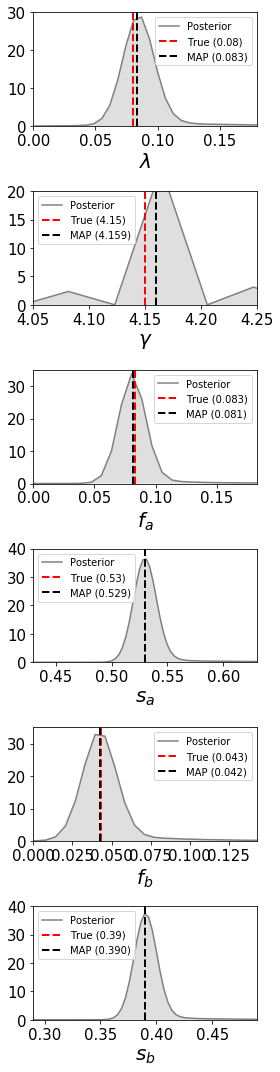

In [13]:
def plot_posterior():
    real=[la_real,ga_real, f_real_a, s_real_a,f_real_b,s_real_b]
    heights=[30,20,35,40,35,40]
    maps=np.array([df.la.iloc[0],df.ga.iloc[0],df.f_a.iloc[0],df.s_a.iloc[0],df.f_b.iloc[0],df.s_b.iloc[0]]).astype(float)
    plt.figure(figsize=(4,15))
    labels=[r'$\lambda$',r'$\gamma$',r'$f_a$',r'$s_a$',r'$f_b$',r'$s_b$']
    iterator=0
    for i in range(posterior_mcmc.flatchain.shape[1]):
        plt.subplot(6,1, iterator+1)
        sns.kdeplot(posterior_mcmc.flatchain[:,i],shade=True,color='Gray',label='Posterior',bw=.01)
        plt.plot([real[i],real[i]],[0,heights[i]],'--r',lw=2,label=f'True ({real[i]})')
        plt.plot([maps[i],maps[i]],[0,heights[i]],'--k',lw=2,label=f'MAP ({str(maps[i])[:5]})')
        plt.ylim([0,heights[i]])
        plt.legend(fontsize=10)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlabel(f'{labels[i]}',fontsize=20)
        iterator+=1
        plt.xlim([np.max((0,real[i]-.1)),real[i]+.1])
    plt.tight_layout()
    plt.show()
    plt.close()
plot_posterior()

And with the experimental data:

In [14]:
counts_alpha=np.array([818819, 795095, 73104, 7880, 1560, 558, 212, 131, 67, 46, 24, 12, 16, 11, 3, 3, 1, 1, 3, 1, 1, 2])
counts_beta=np.array([602628, 989821, 90413, 10733, 2261, 762, 376, 224, 116, 75, 54, 25, 14, 18, 10, 4, 5, 1, 1, 5, 2, 1, 1])

counts_alpha=counts_alpha[:12]
counts_beta=counts_beta[:12]

In [15]:
df=estimate_MAP()
posterior_mcmc=MCMC()

In [16]:
def plot_posterior():
    heights=[30,30,35,40,35,40]
    maps=np.array([df.la.iloc[0],df.ga.iloc[0],df.f_a.iloc[0],df.s_a.iloc[0],df.f_b.iloc[0],df.s_b.iloc[0]]).astype(float)
    plt.figure(figsize=(4,15))
    labels=[r'$\lambda$',r'$\gamma$',r'$f_a$',r'$s_a$',r'$f_b$',r'$s_b$']
    iterator=0
    for i in range(posterior_mcmc.flatchain.shape[1]):
        plt.subplot(6,1, iterator+1)
        sns.kdeplot(posterior_mcmc.flatchain[:,i],shade=True,color='Gray',label='Posterior',bw=.01)
        plt.plot([maps[i],maps[i]],[0,heights[i]],'--k',lw=2,label=f'MAP ({str(maps[i])[:5]})')
        plt.ylim([0,heights[i]])
        plt.legend(fontsize=10)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=15)
        plt.xlabel(f'{labels[i]}',fontsize=20)
        iterator+=1
        plt.xlim([np.max((0,maps[i]-.1)),maps[i]+.1])
    plt.tight_layout()
    plt.show()
    plt.close()

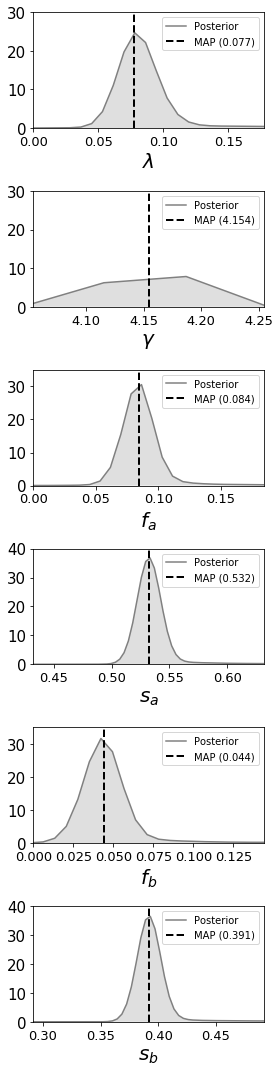

In [17]:
plot_posterior()